In [ ]:
!python -m spacy download xx_ent_wiki_sm
!pip install graphviz
!pip install pydot

  Using cached https://github.com/explosion/spacy-models/releases/download/xx_ent_wiki_sm-3.7.0/xx_ent_wiki_sm-3.7.0-py3-none-any.whl (11.1 MB)
✔ Download and installation successful
You can now load the package via spacy.load('xx_ent_wiki_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.models import Model, clone_model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
from lvclassify_helpers import getdata10cat, getlvstopwords

#### Datu ielāde, kategorijas vērtības kodēšana

In [ ]:
df = getdata10cat()
le = LabelEncoder().fit(df["category"])
df['encod_cat'] = le.transform(df['category'])
# Sanity-check kategorijas datu kodējumam
print(df.head(5))
print(df.category.value_counts())
print(df.encod_cat.value_counts())

  category                                               body  encod_cat
0   Sports  Reaģējot uz  Latvijas Paralimpiskās komitejas ...          8
1   Sports  Latvijas tenisiste  Jeļena Ostapenko  šodien Ķ...          8
2   Sports  Latvijas Sporta federāciju padome  (LSFP) iebi...          8
3   Sports  Jaunais sporta finansējuma modelis samazinās f...          8
4   Sports  Aleksandrs  un  Mihails Samoilovi  piektdien S...          8
category
Sports           1200
Politika         1200
Literatūra       1200
Finanses         1200
Atpūta           1200
Kriminālziņas    1200
Kino             1200
Mūzika           1200
Auto             1200
Tehnoloģijas     1200
Name: count, dtype: int64
encod_cat
8    1200
7    1200
5    1200
2    1200
0    1200
4    1200
3    1200
6    1200
1    1200
9    1200
Name: count, dtype: int64


#### Sadalam datus 80/20

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    df['body'], df['encod_cat'], test_size=.2, stratify=df['encod_cat'], random_state=42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(9600,) (2400,) (9600,) (2400,)


#### Priekšapstrāde, izlīdzinam rindu garumu

In [ ]:
punct = string.punctuation
stopwords_arr = getlvstopwords()

def datu_prieksapstrade(train_sentences):
    return [" ".join([word for word in sentence.lower().split() if word not in stopwords_arr and word not in punct]) for sentence in train_sentences]

vocab_size = 20000
max_len = 512

def datu_prieksapstrade_tokenizacija_izlidzinasana(x_train, x_test, apstrades_funkc=None):
    if apstrades_funkc:
        x_train_ar_apstradi = apstrades_funkc(x_train)
        x_test_ar_apstradi = apstrades_funkc(x_test)
    else:
        x_train_ar_apstradi = x_train.copy()
        x_test_ar_apstradi = x_test.copy()

    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(x_train_ar_apstradi)
    x_seq_train = tokenizer.texts_to_sequences(x_train_ar_apstradi)
    x_seq_test = tokenizer.texts_to_sequences(x_test_ar_apstradi)
    padding_type = 'post'
    x_train_padded = pad_sequences(x_seq_train, padding=padding_type, maxlen=max_len)
    x_test_padded = pad_sequences(x_seq_test, padding=padding_type, maxlen=max_len)

    return x_train_padded, x_test_padded, tokenizer

x_train_ar_apstradi, x_test_ar_apstradi, tokenizer = datu_prieksapstrade_tokenizacija_izlidzinasana(x_train, x_test, apstrades_funkc=datu_prieksapstrade)
x_train_bez_apstrades, x_test_bez_apstrades, tokenizer = datu_prieksapstrade_tokenizacija_izlidzinasana(x_train, x_test)


#### Neironu tīkla izveide ar konvolūcijas slāni - bāzes modelis

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 512)          10240000  
                                                                 
 conv1d (Conv1D)             (None, 508, 256)          655616    
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 10)                2570      
                                                                 
Total params: 10898186 (41.57 MB)
Trainable params: 10898186 (41.57 MB)
Non-trainable params: 0 (0.00 Byte)
______________

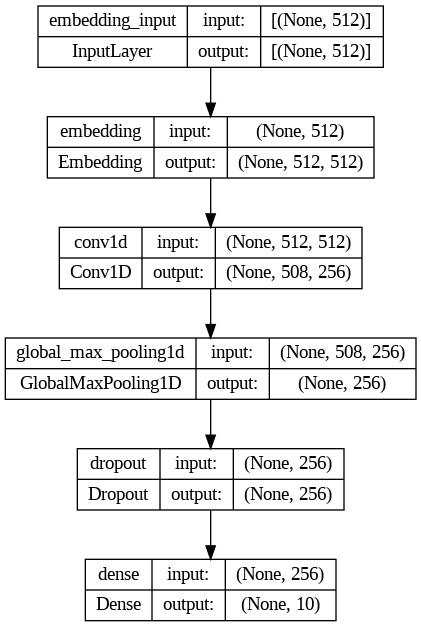

In [ ]:
def knt_modelis(embedding_dim, fastTextSvari=None):
    model = tf.keras.Sequential()

    if fastTextSvari is not None:
        model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len, weights=[fastTextSvari], trainable=False))
    else:
        model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len))

    model.add(tf.keras.layers.Conv1D(256, 5, activation='relu'))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(df['category'].nunique(), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

model_base_ar_apstradi = knt_modelis(512)
model_base_ar_apstradi.summary()
plot_model(model_base_ar_apstradi, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### Paralēlās konvolūcijas (Kim Yoon) modelis

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 512, 512)             1024000   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 dropout_1 (Dropout)         (None, 512, 512)             0         ['embedding_1[0][0]']         
                                                                                                  
 conv1d_1 (Conv1D)           (None, 510, 256)             393472    ['dropout_1[0][0]']       

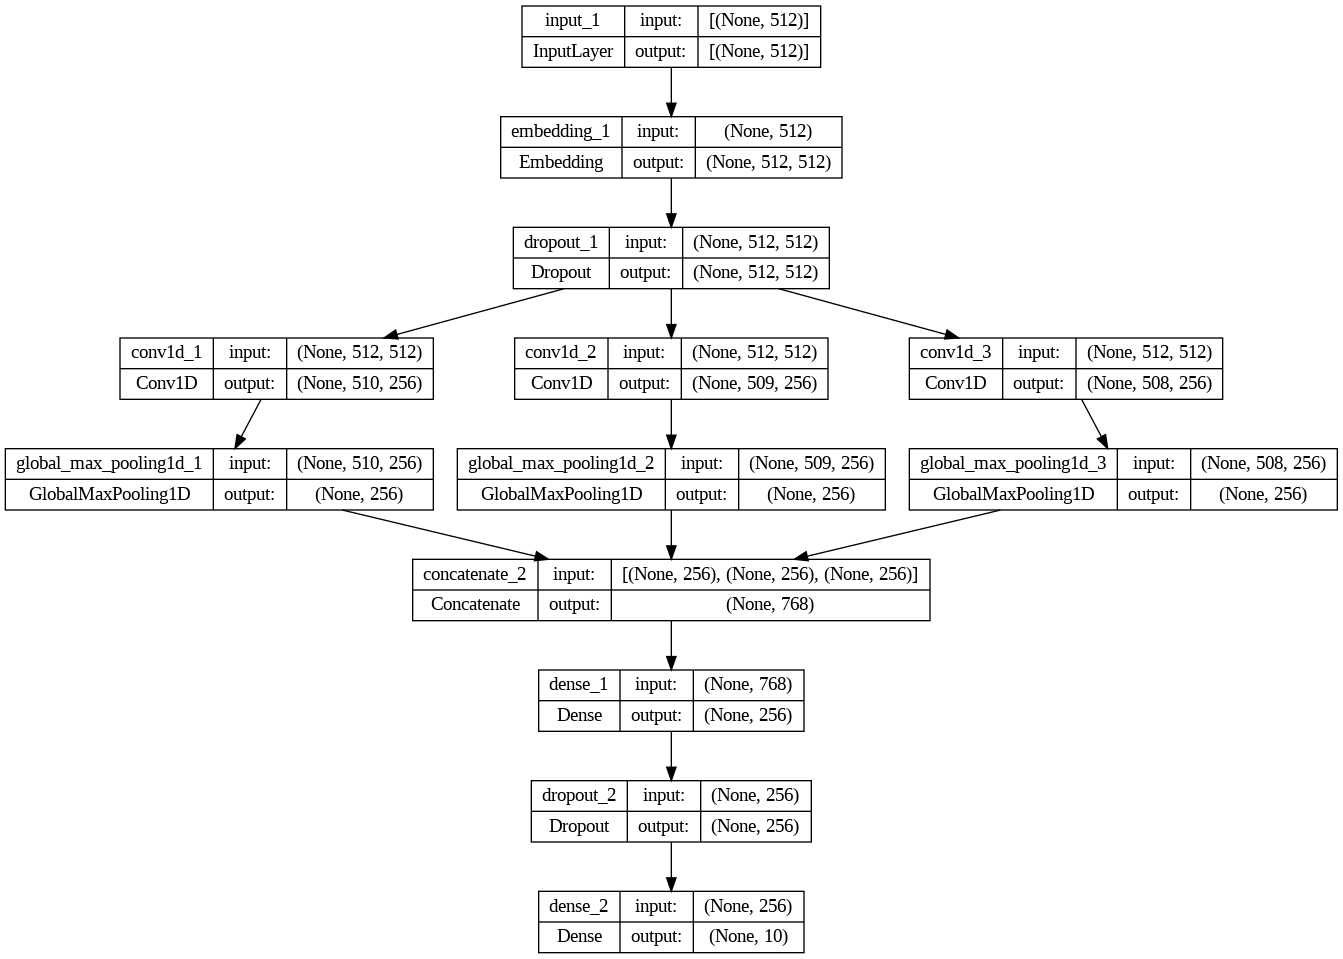

In [ ]:
def kim_knt_modelis(embedding_dim, filtra_izmeri, fastTextSvari=None):
    inputs = Input(shape=(max_len,))

    if fastTextSvari is not None:
        embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, weights=[fastTextSvari], trainable=False)(inputs)
    else:
        embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs)

    embedding_layer = Dropout(0.2)(embedding_layer)

    conv_layers = []
    for filtra_izmers in filtra_izmeri:
        conv_layer = Conv1D(filters=256, kernel_size=filtra_izmers, activation='relu')(embedding_layer)
        pool_layer = GlobalMaxPooling1D()(conv_layer)
        conv_layers.append(pool_layer)
        merged = Concatenate()(conv_layers)

    dense_layer = Dense(256, activation='relu')(merged)
    dense_layer = Dropout(0.2)(dense_layer)
    outputs = Dense(10, activation='softmax')(dense_layer)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_multichannel = kim_knt_modelis(512, [3, 4, 5])
model_multichannel.summary()
plot_model(model_multichannel, to_file='model_plot_KNT_multichannel.png', show_shapes=True, show_layer_names=True)

Izveidojam kopijas pirms apmācības, pārbaudei ar apstrādātiem / neapstrādātiem rakstiem

In [ ]:
model_base_bez_apstrades = knt_modelis(512)
model_multichannel_bez_apstrades = kim_knt_modelis(512, [3, 4, 5])

#### Apmācam neironu tīklus 10 epohos

In [ ]:
%%time
rezultats_ar_apstradi = model_base_ar_apstradi.fit(x_train_ar_apstradi, y_train, epochs=10,  batch_size = 32, validation_data=(x_test_ar_apstradi, y_test), verbose=1,
                           callbacks=[ModelCheckpoint(filepath='./drive/MyDrive/models/KNT_model_ar_apstradi.h5',save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),
                                      EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/10
300/300 [==============================] - 58s 190ms/step - loss: 0.9737 - accuracy: 0.7131 - val_loss: 0.2500 - val_accuracy: 0.9275
Epoch 2/10
300/300 [==============================] - 52s 172ms/step - loss: 0.1831 - accuracy: 0.9495 - val_loss: 0.1613 - val_accuracy: 0.9571
Epoch 3/10
300/300 [==============================] - 52s 172ms/step - loss: 0.0610 - accuracy: 0.9836 - val_loss: 0.1547 - val_accuracy: 0.9571
Epoch 4/10
300/300 [==============================] - 52s 173ms/step - loss: 0.0243 - accuracy: 0.9948 - val_loss: 0.1503 - val_accuracy: 0.9617
Epoch 5/10
300/300 [==============================] - 52s 173ms/step - loss: 0.0155 - accuracy: 0.9969 - val_loss: 0.1630 - val_accuracy: 0.9563
Epoch 6/10
300/300 [==============================] - 51s 171ms/step - loss: 0.0082 - accuracy: 0.9989 - val_loss: 0.1633 - val_accuracy: 0.9592
CPU times: user 1h 40min 6s, sys: 44min 38s, total: 2h 24min 44s
Wall time: 5min 16s


In [ ]:
%%time
rezultats_bez_apstrades = model_base_bez_apstrades.fit(x_train_bez_apstrades, y_train, epochs=10,  batch_size = 32, validation_data=(x_test_bez_apstrades, y_test), verbose=1,
                           callbacks=[ModelCheckpoint(filepath='./drive/MyDrive/models/KNT_model_bez_apstrades.h5',save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),
                                      EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/10
300/300 [==============================] - 54s 178ms/step - loss: 1.0408 - accuracy: 0.6991 - val_loss: 0.2527 - val_accuracy: 0.9287
Epoch 2/10
300/300 [==============================] - 51s 169ms/step - loss: 0.1983 - accuracy: 0.9465 - val_loss: 0.1682 - val_accuracy: 0.9504
Epoch 3/10
300/300 [==============================] - 51s 170ms/step - loss: 0.0658 - accuracy: 0.9842 - val_loss: 0.1537 - val_accuracy: 0.9546
Epoch 4/10
300/300 [==============================] - 50s 166ms/step - loss: 0.0299 - accuracy: 0.9941 - val_loss: 0.1543 - val_accuracy: 0.9554
Epoch 5/10
300/300 [==============================] - 51s 170ms/step - loss: 0.0174 - accuracy: 0.9967 - val_loss: 0.1516 - val_accuracy: 0.9533
Epoch 6/10
300/300 [==============================] - 50s 168ms/step - loss: 0.0101 - accuracy: 0.9983 - val_loss: 0.1534 - val_accuracy: 0.9571
Epoch 7/10
300/300 [==============================] - 50s 168ms/step - loss: 0.0066 - accuracy: 0.9987 - val_loss: 0.1628 - val_ac

In [ ]:
%%time
rezultats_multichannel_ar_apstradi = model_multichannel.fit(x_train_ar_apstradi, y_train, epochs=10,  batch_size = 32, validation_data=(x_test_ar_apstradi, y_test), verbose=1,
                                                 callbacks=[ModelCheckpoint(filepath='./drive/MyDrive/models/KNT_model_multichannel_ar_apstradi.h5',save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),
                                      EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/10
300/300 [==============================] - 73s 238ms/step - loss: 0.7846 - accuracy: 0.7477 - val_loss: 0.1966 - val_accuracy: 0.9429
Epoch 2/10
300/300 [==============================] - 69s 231ms/step - loss: 0.0988 - accuracy: 0.9689 - val_loss: 0.1377 - val_accuracy: 0.9575
Epoch 3/10
300/300 [==============================] - 69s 230ms/step - loss: 0.0179 - accuracy: 0.9952 - val_loss: 0.1463 - val_accuracy: 0.9600
Epoch 4/10
300/300 [==============================] - 69s 230ms/step - loss: 0.0058 - accuracy: 0.9989 - val_loss: 0.1573 - val_accuracy: 0.9583
CPU times: user 2h 30min 31s, sys: 1h 10min 20s, total: 3h 40min 52s
Wall time: 4min 40s


In [ ]:
%%time
rezultats_multichannel_bez_apstrades = model_multichannel_bez_apstrades.fit(x_train_bez_apstrades, y_train, epochs=10,  batch_size = 32, validation_data=(x_test_bez_apstrades, y_test), verbose=1,
                                                 callbacks=[ModelCheckpoint(filepath='./drive/MyDrive/models/KNT_model_multichannel_bez_apstrades.h5',save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),
                                      EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/10
300/300 [==============================] - 73s 241ms/step - loss: 0.8652 - accuracy: 0.7159 - val_loss: 0.2095 - val_accuracy: 0.9367
Epoch 2/10
300/300 [==============================] - 70s 232ms/step - loss: 0.1165 - accuracy: 0.9655 - val_loss: 0.1715 - val_accuracy: 0.9533
Epoch 3/10
300/300 [==============================] - 70s 232ms/step - loss: 0.0194 - accuracy: 0.9957 - val_loss: 0.1618 - val_accuracy: 0.9558
Epoch 4/10
300/300 [==============================] - 69s 230ms/step - loss: 0.0066 - accuracy: 0.9990 - val_loss: 0.1795 - val_accuracy: 0.9563
Epoch 5/10
300/300 [==============================] - 68s 228ms/step - loss: 0.0030 - accuracy: 0.9999 - val_loss: 0.1759 - val_accuracy: 0.9613
CPU times: user 3h 7min 42s, sys: 1h 29min 1s, total: 4h 36min 43s
Wall time: 5min 50s


#### Iegūto modeļu novērtējums, apmācības vizualizācija

75/75 [==============================] - 2s 22ms/step
              precision    recall  f1-score   support

           0     0.9549    0.9708    0.9628       240
           1     0.9752    0.9833    0.9793       240
           2     0.9322    0.9167    0.9244       240
           3     0.9793    0.9833    0.9813       240
           4     0.9707    0.9667    0.9687       240
           5     0.9791    0.9750    0.9770       240
           6     0.9668    0.9708    0.9688       240
           7     0.9538    0.9458    0.9498       240
           8     0.9793    0.9875    0.9834       240
           9     0.9244    0.9167    0.9205       240

    accuracy                         0.9617      2400
   macro avg     0.9616    0.9617    0.9616      2400
weighted avg     0.9616    0.9617    0.9616      2400



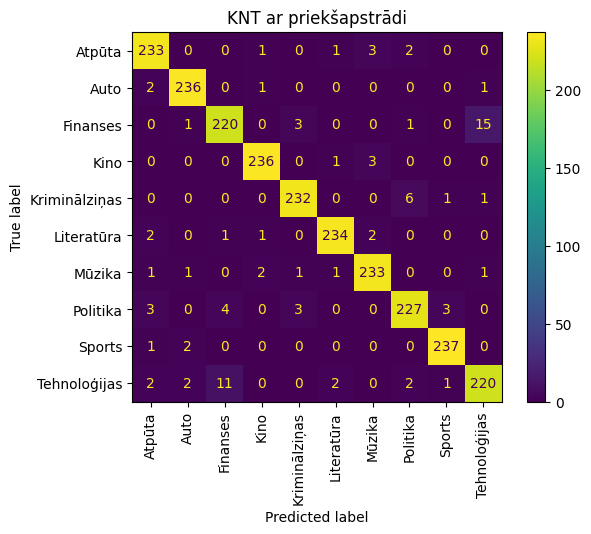

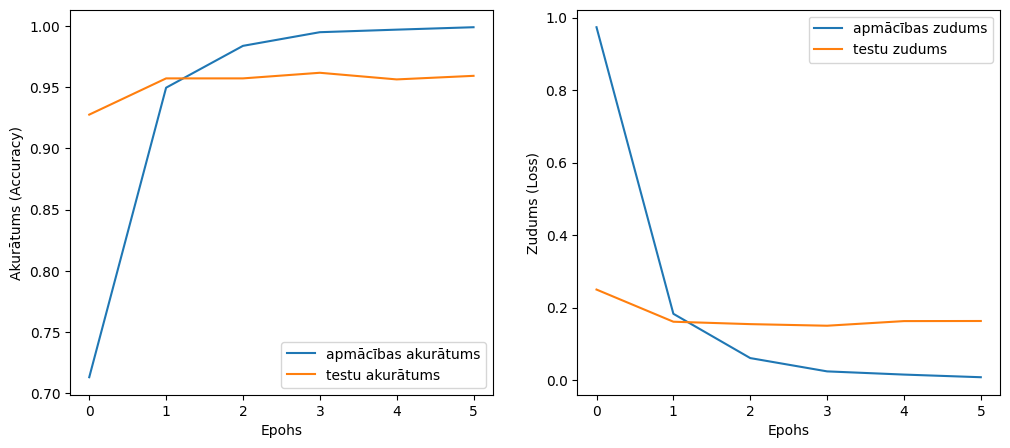

75/75 [==============================] - 2s 22ms/step
              precision    recall  f1-score   support

           0     0.9243    0.9667    0.9450       240
           1     0.9669    0.9750    0.9710       240
           2     0.9208    0.9208    0.9208       240
           3     0.9792    0.9792    0.9792       240
           4     0.9630    0.9750    0.9689       240
           5     0.9749    0.9708    0.9729       240
           6     0.9547    0.9667    0.9607       240
           7     0.9449    0.9292    0.9370       240
           8     0.9791    0.9750    0.9770       240
           9     0.9251    0.8750    0.8994       240

    accuracy                         0.9533      2400
   macro avg     0.9533    0.9533    0.9532      2400
weighted avg     0.9533    0.9533    0.9532      2400



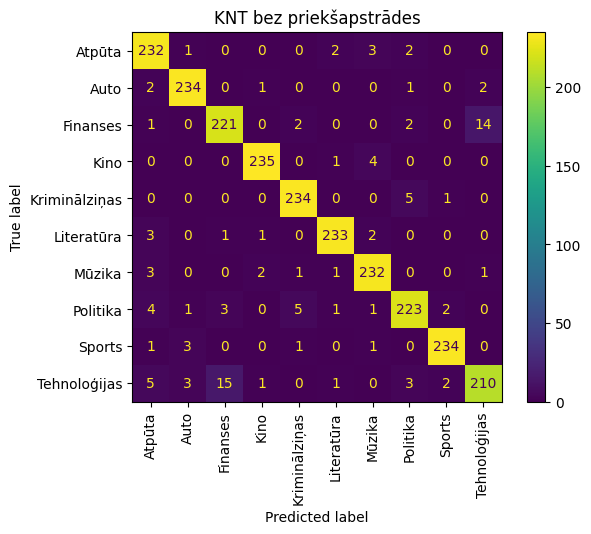

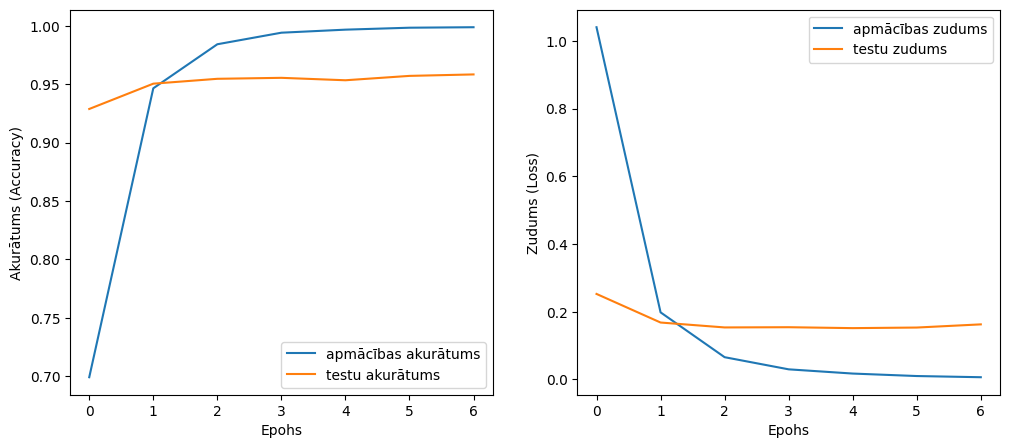

75/75 [==============================] - 2s 29ms/step
              precision    recall  f1-score   support

           0     0.9665    0.9625    0.9645       240
           1     0.9751    0.9792    0.9771       240
           2     0.9277    0.9083    0.9179       240
           3     0.9793    0.9833    0.9813       240
           4     0.9870    0.9500    0.9682       240
           5     0.9829    0.9583    0.9705       240
           6     0.9549    0.9708    0.9628       240
           7     0.9098    0.9667    0.9374       240
           8     0.9832    0.9750    0.9791       240
           9     0.9132    0.9208    0.9170       240

    accuracy                         0.9575      2400
   macro avg     0.9580    0.9575    0.9576      2400
weighted avg     0.9580    0.9575    0.9576      2400



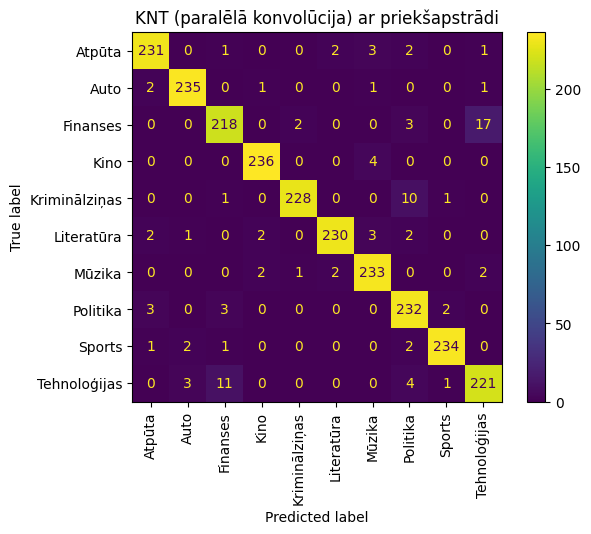

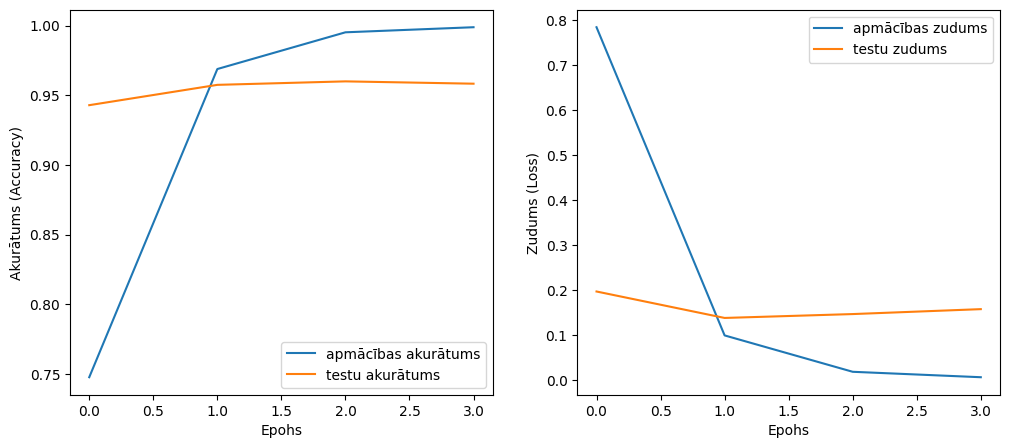

75/75 [==============================] - 2s 30ms/step
              precision    recall  f1-score   support

           0     0.9827    0.9458    0.9639       240
           1     0.9874    0.9792    0.9833       240
           2     0.9450    0.8583    0.8996       240
           3     0.9793    0.9833    0.9813       240
           4     0.9627    0.9667    0.9647       240
           5     0.9549    0.9708    0.9628       240
           6     0.9508    0.9667    0.9587       240
           7     0.9458    0.9458    0.9458       240
           8     0.9835    0.9958    0.9896       240
           9     0.8731    0.9458    0.9080       240

    accuracy                         0.9558      2400
   macro avg     0.9565    0.9558    0.9558      2400
weighted avg     0.9565    0.9558    0.9558      2400



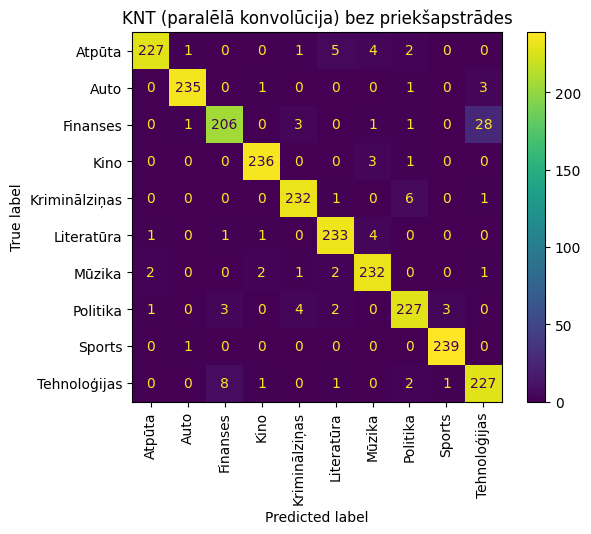

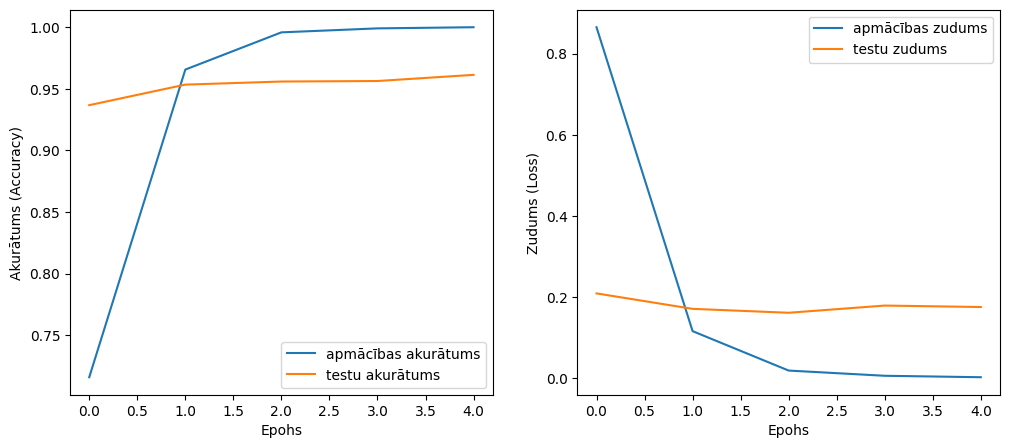

In [ ]:
def modela_novertesana(model, x_test_val, y_test_val, title):
    y_pred = model.predict(x_test_val)
    y_pred = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_test_val, y_pred)

    labels = ['Atpūta', 'Auto', 'Finanses', 'Kino', 'Kriminālziņas', 'Literatūra', 'Mūzika', 'Politika', 'Sports', 'Tehnoloģijas']
    plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plot.plot(xticks_rotation=90)
    plot.ax_.set_title(title)

    print(classification_report(y_test, y_pred, digits=4))

def plot_apmacibas_rezultats(rezultats):
    plt.figure(figsize=(12, 5))

    ax = plt.subplot(121)
    plt.plot(rezultats.history['accuracy'])
    plt.plot(rezultats.history['val_accuracy'])
    plt.xlabel("Epohs")
    plt.ylabel("Akurātums (Accuracy)")
    plt.legend(['apmācības akurātums', 'testu akurātums'])

    plt.subplot(122)
    plt.plot(rezultats.history['loss'])
    plt.plot(rezultats.history['val_loss'])
    plt.xlabel("Epohs")
    plt.ylabel("Zudums (Loss)")
    plt.legend(['apmācības zudums', 'testu zudums'])

    plt.show()

# Ielādējam svarus no epoha ar mazāko validācijas zuduma vērtību
model_base_ar_apstradi.load_weights('./drive/MyDrive/models/KNT_model_ar_apstradi.h5')
model_base_bez_apstrades.load_weights('./drive/MyDrive/models/KNT_model_bez_apstrades.h5')
model_multichannel.load_weights('./drive/MyDrive/models/KNT_model_multichannel_ar_apstradi.h5')
model_multichannel_bez_apstrades.load_weights('./drive/MyDrive/models/KNT_model_multichannel_bez_apstrades.h5')

modela_novertesana(model_base_ar_apstradi, x_test_ar_apstradi, y_test, "KNT ar priekšapstrādi")
plot_apmacibas_rezultats(rezultats_ar_apstradi)
modela_novertesana(model_base_bez_apstrades, x_test_bez_apstrades, y_test, "KNT bez priekšapstrādes")
plot_apmacibas_rezultats(rezultats_bez_apstrades)
modela_novertesana(model_multichannel, x_test_ar_apstradi, y_test, "KNT (paralēlā konvolūcija) ar priekšapstrādi")
plot_apmacibas_rezultats(rezultats_multichannel_ar_apstradi)
modela_novertesana(model_multichannel_bez_apstrades, x_test_bez_apstrades, y_test, "KNT (paralēlā konvolūcija) bez priekšapstrādes")
plot_apmacibas_rezultats(rezultats_multichannel_bez_apstrades)


### Pārbaude ar dažādiem datu kopā neiekļautiem rakstiem

In [ ]:
def getLabel(index):
    labels = ['Atpūta', 'Auto', 'Finanses', 'Kino', 'Kriminālziņas', 'Literatūra', 'Mūzika', 'Politika', 'Sports', 'Tehnoloģijas']
    return labels[index]

In [ ]:
def predict(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=512)
    prediction = model_base_bez_apstrades.predict(padded)
    predictionList = prediction.tolist()[0]
    labeled_predictions = [{getLabel(i):"%.2f%%"%(x*100)} for i, x in enumerate(predictionList)]
    return labeled_predictions

In [ ]:
# Politika
predict("""Pirmdien, 4. septembrī, premjera amatam nominētā Evika Siliņa (JV) sāks nākamās koalīcijas sarunas, dalot ministru amatus "Jaunās Vienotības", Zaļo un zemnieku savienības (ZZS) un partijas "Progresīvie" starpā.

Piektdien, 1. septembrī, Siliņa preses konferencē informēja, ka, "Apvienotajam sarakstam" nepiekrītot darboties nākamajā koalīcijā, tajā darbosies trīs politiskie spēki, kuriem Saeimā kopumā ir 52 balsis.

Siliņa gan neizslēdza iespēju, ka ar laiku koalīcijai varētu pievienoties vēl kāds partneris. "Vienmēr pastāv iespēja iegūt vairāk balsis, ja labi strādā," teica Siliņa.

Kā viens no potenciālajiem nākamās koalīcijas atbalstītājiem varētu būt pie frakcijām nepiederošais Oļegs Burovs, ar kuru Siliņa gan neesot runājusi, bet to darot cits nākamās koalīcijas partneris.""")

1/1 [==============================] - 0s 65ms/step


[{'Atpūta': '0.00%'},
 {'Auto': '0.02%'},
 {'Finanses': '0.02%'},
 {'Kino': '0.01%'},
 {'Kriminālziņas': '0.01%'},
 {'Literatūra': '0.02%'},
 {'Mūzika': '0.02%'},
 {'Politika': '99.80%'},
 {'Sports': '0.00%'},
 {'Tehnoloģijas': '0.09%'}]

In [ ]:
# Tehnoloģijas
predict("""Starptautiskais pašapkalpošanās un automatizācijas risinājumu ražotājs "Omnic" Liepājā būvēs jaunu rūpnīcu, lai ražotu pakomātus Eiropas tirgum, liecina uzņēmuma sniegtā informācija.

Šobrīd vēl tiek precizēta potenciāli vislabākā atrašanās vieta ražotnei, bet pirmie būvdarbi varētu tikt uzsākti jau šogad.

Darbu jaunā rūpnīca varētu sākt 2024. gadā.

Kā norāda uzņēmumā, šobrīd vēl esot grūti pateikt precīzas Liepājas rūpnīcas izmaksas, bet līdzīgā ražotnē Gruzijā "Omnic" investēja 8 miljonus eiro.

Liepājas rūpnīcā plānots ražot paku skapīšus, pašapkalpošanās kases aparātus, ar saules paneļiem aprīkotus pakomātus, paku skapīšus-ledusskapjus, kā arī dažādus citus pašapkalpošanās un automatizācijas risinājumus.""")

1/1 [==============================] - 0s 25ms/step


[{'Atpūta': '0.07%'},
 {'Auto': '0.23%'},
 {'Finanses': '8.80%'},
 {'Kino': '0.03%'},
 {'Kriminālziņas': '0.44%'},
 {'Literatūra': '0.01%'},
 {'Mūzika': '0.01%'},
 {'Politika': '0.09%'},
 {'Sports': '0.01%'},
 {'Tehnoloģijas': '90.31%'}]

In [ ]:
# Kriminālziņas
predict("""Aizvadītajā diennaktī valstī reģistrēti 136 ceļu satiksmes negadījumi, tajos cietušas 13 personas, liecina Valsts policijas apkopotie dati.

Četri no cietušajiem bijuši gājēji, tāpat cietis viens velosipēdists un viens elektrisko skrejriteņu vadītājs.

Kopumā ceļu satiksmes jomā pieņemti 456 administratīvo pārkāpumu lēmumi, tajā skaitā 195 par ātruma pārsniegšanu un viens par agresīvu braukšanu.""")

1/1 [==============================] - 0s 25ms/step


[{'Atpūta': '0.00%'},
 {'Auto': '0.00%'},
 {'Finanses': '0.02%'},
 {'Kino': '0.01%'},
 {'Kriminālziņas': '99.71%'},
 {'Literatūra': '0.01%'},
 {'Mūzika': '0.00%'},
 {'Politika': '0.20%'},
 {'Sports': '0.00%'},
 {'Tehnoloģijas': '0.06%'}]

In [ ]:
# Sports
predict("""Serbijas tenisists Novaks Džokovičs piektdien ASV atklātā čempionāta trešās kārtas spēlē pret savu tautieti Laslo Džeri zaudēja pirmajos divos setos, tomēr atspēlējās un svinēja uzvaru.

Ranga vicelīderis Džokovičs ATP 38.numuru Džeri vairāk nekā trīsarpus stundu cīņā uzvarēja ar rezultātu 4-6, 4-6, 6-1, 6-1, 6-3.

Kopš 2007.gada Džokovičs visos "US Open" turnīros, kuros piedalījies, ticis tālāk par trešo kārtu, 2011., 2015. un 2018.gadā kļūstot par čempionu.

"Esmu parādījis, ka varu aizvadīt arī piecu setu mačus. Atspēlēšanās pēc diviem zaudētiem setiem rāda skaidru signālu maniem nākamajiem pretiniekiem, taču nav tā, ka vēlējos nonākt šādā situācijā. Labprāt uzvarētu trīs setos," pēc uzvaras teica Džokovičs.""")

1/1 [==============================] - 0s 26ms/step


[{'Atpūta': '0.00%'},
 {'Auto': '0.13%'},
 {'Finanses': '0.03%'},
 {'Kino': '0.00%'},
 {'Kriminālziņas': '0.00%'},
 {'Literatūra': '0.00%'},
 {'Mūzika': '0.00%'},
 {'Politika': '0.00%'},
 {'Sports': '99.82%'},
 {'Tehnoloģijas': '0.00%'}]

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.lv.300.bin.gz

--2024-05-21 10:42:41--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.lv.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.11, 3.162.163.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4106747743 (3.8G) [application/octet-stream]
Saving to: ‘cc.lv.300.bin.gz’

cc.lv.300.bin.gz    100%[===================>]   3.82G   338MB/s    in 11s     

2024-05-21 10:42:52 (351 MB/s) - ‘cc.lv.300.bin.gz’ saved [4106747743/4106747743]



In [ ]:
from gensim.models import fasttext
import logging
import numpy as np
logging.getLogger('gensim').setLevel(logging.ERROR)
vect_ft = fasttext.load_facebook_vectors('cc.lv.300.bin.gz')

vocab_size = len(vect_ft.key_to_index)
embedding_dim = vect_ft.vector_size

embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = tokenizer.word_index
for word, i in word_index.items():
    try:
        embedding_vector = vect_ft[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.random.normal(size=(embedding_dim,))

In [ ]:
model_base_ar_apstradi_ft = knt_modelis(300, fastTextSvari=embedding_matrix)
model_base_bez_apstrades_ft = knt_modelis(300, fastTextSvari=embedding_matrix)
model_multichannel_ar_apstradi_ft = kim_knt_modelis(300, [3, 4, 5], fastTextSvari=embedding_matrix)
model_multichannel_bez_apstrades_ft =  kim_knt_modelis(300, [3, 4, 5], fastTextSvari=embedding_matrix)

In [ ]:
%%time
rezultats_ar_apstradi_ft = model_base_ar_apstradi_ft.fit(x_train_ar_apstradi, y_train, epochs=30,  batch_size = 32, validation_data=(x_test_ar_apstradi, y_test), verbose=1,
                           callbacks=[ModelCheckpoint(filepath='./drive/MyDrive/models/KNT_model_ar_apstradi_ft.h5',save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),
                                      EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/30
300/300 [==============================] - 26s 72ms/step - loss: 1.7142 - accuracy: 0.4401 - val_loss: 1.0893 - val_accuracy: 0.7117
Epoch 2/30
300/300 [==============================] - 22s 72ms/step - loss: 0.9727 - accuracy: 0.7064 - val_loss: 0.7229 - val_accuracy: 0.7979
Epoch 3/30
300/300 [==============================] - 25s 85ms/step - loss: 0.7012 - accuracy: 0.7949 - val_loss: 0.5682 - val_accuracy: 0.8363
Epoch 4/30
300/300 [==============================] - 64s 214ms/step - loss: 0.5527 - accuracy: 0.8378 - val_loss: 0.4972 - val_accuracy: 0.8475
Epoch 5/30
300/300 [==============================] - 22s 72ms/step - loss: 0.4601 - accuracy: 0.8670 - val_loss: 0.4390 - val_accuracy: 0.8687
Epoch 6/30
300/300 [==============================] - 22s 72ms/step - loss: 0.3897 - accuracy: 0.8913 - val_loss: 0.3986 - val_accuracy: 0.8800
Epoch 7/30
300/300 [==============================] - 108s 362ms/step - loss: 0.3223 - accuracy: 0.9140 - val_loss: 0.3776 - val_accura

In [ ]:
%%time
rezultats_bez_apstrades_ft = model_base_bez_apstrades_ft.fit(x_train_bez_apstrades, y_train, epochs=30,  batch_size = 32, validation_data=(x_test_bez_apstrades, y_test), verbose=1,
                           callbacks=[ModelCheckpoint(filepath='./drive/MyDrive/models/KNT_model_bez_apstrades_ft.h5',save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),
                                      EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/30
300/300 [==============================] - 33s 109ms/step - loss: 1.5564 - accuracy: 0.5003 - val_loss: 0.8412 - val_accuracy: 0.8204
Epoch 2/30
300/300 [==============================] - 21s 71ms/step - loss: 0.6602 - accuracy: 0.8264 - val_loss: 0.4189 - val_accuracy: 0.8950
Epoch 3/30
300/300 [==============================] - 21s 70ms/step - loss: 0.3829 - accuracy: 0.8964 - val_loss: 0.3053 - val_accuracy: 0.9133
Epoch 4/30
300/300 [==============================] - 109s 364ms/step - loss: 0.2880 - accuracy: 0.9176 - val_loss: 0.2499 - val_accuracy: 0.9321
Epoch 5/30
300/300 [==============================] - 21s 69ms/step - loss: 0.2187 - accuracy: 0.9405 - val_loss: 0.2174 - val_accuracy: 0.9396
Epoch 6/30
300/300 [==============================] - 22s 75ms/step - loss: 0.1727 - accuracy: 0.9545 - val_loss: 0.1996 - val_accuracy: 0.9450
Epoch 7/30
300/300 [==============================] - 107s 357ms/step - loss: 0.1434 - accuracy: 0.9614 - val_loss: 0.1854 - val_accu

In [ ]:
%%time
rezultats_multichannel_ar_apstradi_ft = model_multichannel_ar_apstradi_ft.fit(x_train_ar_apstradi, y_train, epochs=30,  batch_size = 32, validation_data=(x_test_ar_apstradi, y_test), verbose=1,
                                                 callbacks=[ModelCheckpoint(filepath='./drive/MyDrive/models/KNT_model_multichannel_ar_apstradi_ft.h5',save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),
                                      EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/30
300/300 [==============================] - 34s 110ms/step - loss: 1.4326 - accuracy: 0.5127 - val_loss: 0.6983 - val_accuracy: 0.7696
Epoch 2/30
300/300 [==============================] - 30s 100ms/step - loss: 0.5957 - accuracy: 0.8057 - val_loss: 0.4453 - val_accuracy: 0.8517
Epoch 3/30
300/300 [==============================] - 40s 133ms/step - loss: 0.3678 - accuracy: 0.8832 - val_loss: 0.3814 - val_accuracy: 0.8737
Epoch 4/30
300/300 [==============================] - 83s 279ms/step - loss: 0.2218 - accuracy: 0.9317 - val_loss: 0.3555 - val_accuracy: 0.8800
Epoch 5/30
300/300 [==============================] - 30s 101ms/step - loss: 0.1322 - accuracy: 0.9614 - val_loss: 0.3322 - val_accuracy: 0.8917
Epoch 6/30
300/300 [==============================] - 45s 149ms/step - loss: 0.0777 - accuracy: 0.9807 - val_loss: 0.3250 - val_accuracy: 0.8988
Epoch 7/30
300/300 [==============================] - 74s 248ms/step - loss: 0.0422 - accuracy: 0.9915 - val_loss: 0.2994 - val_ac

In [ ]:
%%time
rezultats_multichannel_bez_apstrades_ft = model_multichannel_bez_apstrades_ft.fit(x_train_bez_apstrades, y_train, epochs=30,  batch_size = 32, validation_data=(x_test_bez_apstrades, y_test), verbose=1,
                                                 callbacks=[ModelCheckpoint(filepath='./drive/MyDrive/models/KNT_model_multichannel_bez_apstrades_ft.h5',save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),
                                      EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/30
300/300 [==============================] - 56s 185ms/step - loss: 1.2477 - accuracy: 0.5808 - val_loss: 0.4289 - val_accuracy: 0.8746
Epoch 2/30
300/300 [==============================] - 30s 101ms/step - loss: 0.3270 - accuracy: 0.8947 - val_loss: 0.2193 - val_accuracy: 0.9321
Epoch 3/30
300/300 [==============================] - 30s 102ms/step - loss: 0.1721 - accuracy: 0.9497 - val_loss: 0.2141 - val_accuracy: 0.9362
Epoch 4/30
300/300 [==============================] - 30s 100ms/step - loss: 0.1089 - accuracy: 0.9668 - val_loss: 0.1860 - val_accuracy: 0.9483
Epoch 5/30
300/300 [==============================] - 23s 78ms/step - loss: 0.0644 - accuracy: 0.9831 - val_loss: 0.1872 - val_accuracy: 0.9433
Epoch 6/30
300/300 [==============================] - 90s 299ms/step - loss: 0.0464 - accuracy: 0.9870 - val_loss: 0.1659 - val_accuracy: 0.9496
Epoch 7/30
300/300 [==============================] - 23s 77ms/step - loss: 0.0275 - accuracy: 0.9935 - val_loss: 0.1804 - val_accu

75/75 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

           0     0.9312    0.9583    0.9446       240
           1     0.9483    0.9167    0.9322       240
           2     0.9091    0.8333    0.8696       240
           3     0.9748    0.9667    0.9707       240
           4     0.9617    0.9417    0.9516       240
           5     0.9244    0.9167    0.9205       240
           6     0.9451    0.9333    0.9392       240
           7     0.8821    0.9042    0.8930       240
           8     0.9339    0.9417    0.9378       240
           9     0.7962    0.8792    0.8356       240

    accuracy                         0.9192      2400
   macro avg     0.9207    0.9192    0.9195      2400
weighted avg     0.9207    0.9192    0.9195      2400



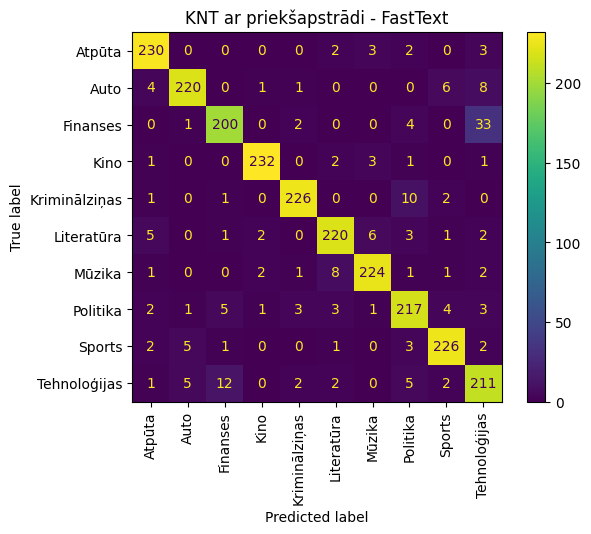

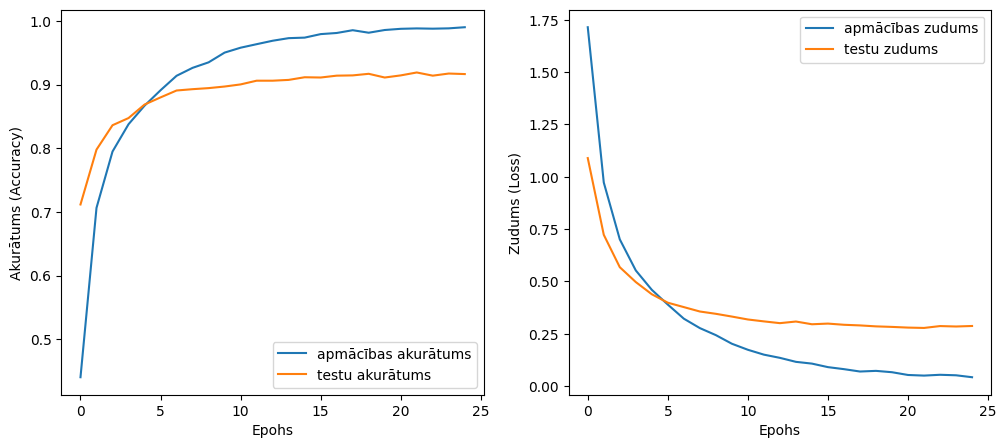

75/75 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

           0     0.9325    0.9792    0.9553       240
           1     0.9671    0.9792    0.9731       240
           2     0.9381    0.8833    0.9099       240
           3     0.9749    0.9708    0.9729       240
           4     0.9710    0.9750    0.9730       240
           5     0.9827    0.9458    0.9639       240
           6     0.9588    0.9708    0.9648       240
           7     0.9461    0.9500    0.9480       240
           8     0.9708    0.9708    0.9708       240
           9     0.8975    0.9125    0.9050       240

    accuracy                         0.9537      2400
   macro avg     0.9539    0.9537    0.9537      2400
weighted avg     0.9539    0.9537    0.9537      2400



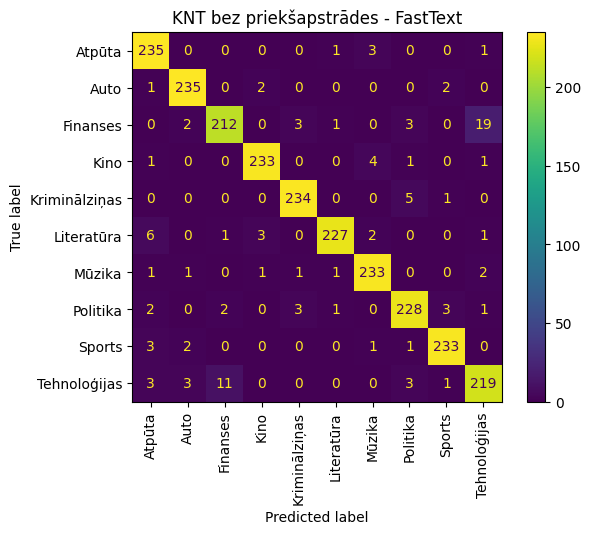

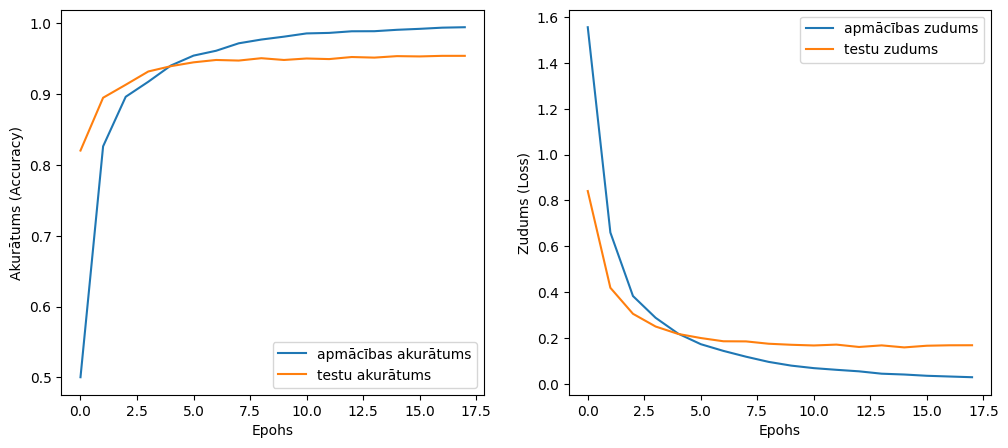

75/75 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0     0.9136    0.9250    0.9193       240
           1     0.9283    0.9167    0.9224       240
           2     0.8238    0.8375    0.8306       240
           3     0.9746    0.9583    0.9664       240
           4     0.9622    0.9542    0.9582       240
           5     0.9383    0.8875    0.9122       240
           6     0.9157    0.9500    0.9325       240
           7     0.8983    0.8833    0.8908       240
           8     0.9520    0.9083    0.9296       240
           9     0.7701    0.8375    0.8024       240

    accuracy                         0.9058      2400
   macro avg     0.9077    0.9058    0.9064      2400
weighted avg     0.9077    0.9058    0.9064      2400



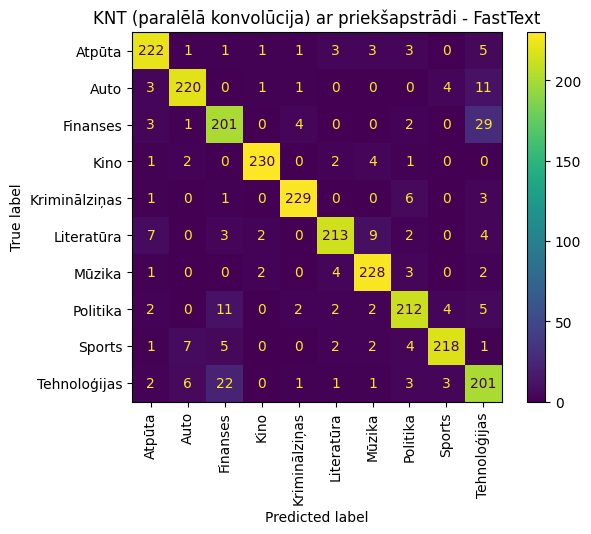

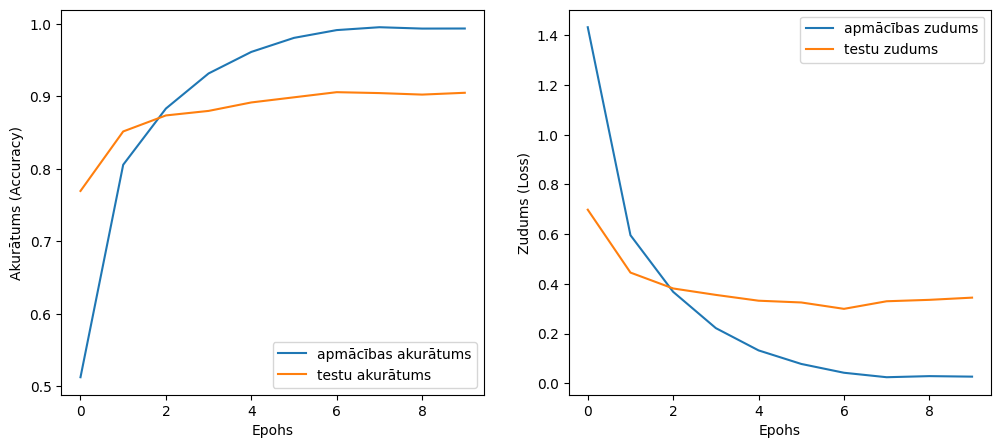

75/75 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0     0.9617    0.9417    0.9516       240
           1     0.9873    0.9750    0.9811       240
           2     0.8924    0.9333    0.9124       240
           3     0.9787    0.9583    0.9684       240
           4     0.9480    0.9875    0.9673       240
           5     0.9435    0.9750    0.9590       240
           6     0.9429    0.9625    0.9526       240
           7     0.9609    0.9208    0.9404       240
           8     0.9593    0.9833    0.9712       240
           9     0.9238    0.8583    0.8898       240

    accuracy                         0.9496      2400
   macro avg     0.9499    0.9496    0.9494      2400
weighted avg     0.9499    0.9496    0.9494      2400



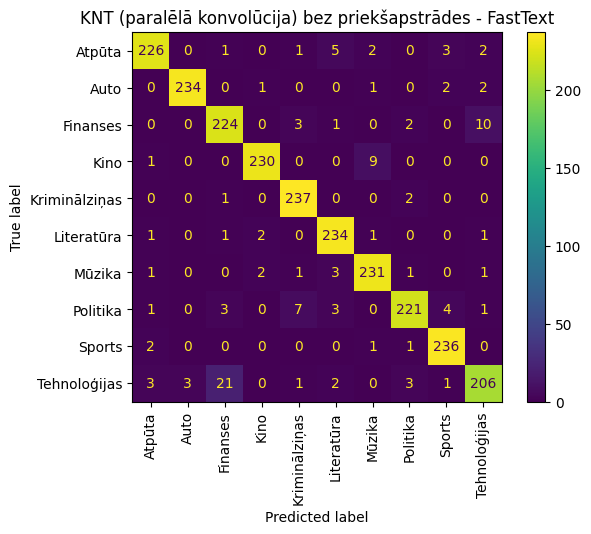

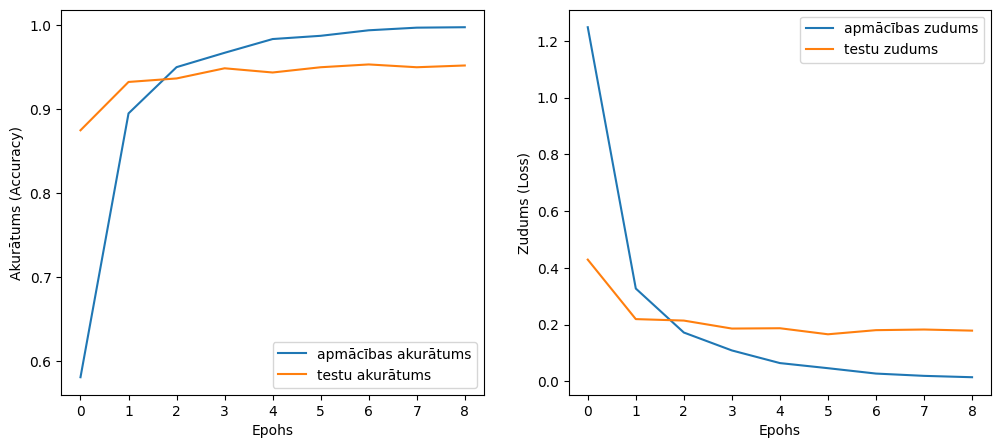

In [ ]:
# Ielādējam svarus no epoha ar mazāko validācijas zuduma vērtību
model_base_ar_apstradi_ft.load_weights('./drive/MyDrive/models/KNT_model_ar_apstradi_ft.h5')
model_base_bez_apstrades_ft.load_weights('./drive/MyDrive/models/KNT_model_bez_apstrades_ft.h5')
model_multichannel_ar_apstradi_ft.load_weights('./drive/MyDrive/models/KNT_model_multichannel_ar_apstradi_ft.h5')
model_multichannel_bez_apstrades_ft.load_weights('./drive/MyDrive/models/KNT_model_multichannel_bez_apstrades_ft.h5')

modela_novertesana(model_base_ar_apstradi_ft, x_test_ar_apstradi, y_test, "KNT ar priekšapstrādi - FastText")
plot_apmacibas_rezultats(rezultats_ar_apstradi_ft)
modela_novertesana(model_base_bez_apstrades_ft, x_test_bez_apstrades, y_test, "KNT bez priekšapstrādes - FastText")
plot_apmacibas_rezultats(rezultats_bez_apstrades_ft)
modela_novertesana(model_multichannel_ar_apstradi_ft, x_test_ar_apstradi, y_test, "KNT (paralēlā konvolūcija) ar priekšapstrādi - FastText")
plot_apmacibas_rezultats(rezultats_multichannel_ar_apstradi_ft)
modela_novertesana(model_multichannel_bez_apstrades_ft, x_test_bez_apstrades, y_test, "KNT (paralēlā konvolūcija) bez priekšapstrādes - FastText")
plot_apmacibas_rezultats(rezultats_multichannel_bez_apstrades_ft)